# Amazon sentiment analysis: Spectral Feature Alignment

Data downloaded from: processed_acl.tar.gz, processed for John Blitzer, Mark Dredze, Fernando Pereira. Biographies, Bollywood, Boom-boxes and Blenders: Domain Adaptation for Sentiment Classification. Association of Computational Linguistics (ACL), 2007

Method:  Spectral Feature Alignment (SFA) by [Pan et al. (2010)
](http://wwwconference.org/proceedings/www2010/www/p751.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from read_funcs import organise_data, vectorise_data, select_high_freq_data
%matplotlib inline

In [2]:
src = 'dvd'
tgt = 'kitchen'
XB, Y_src, XD, Y_tgt = organise_data(src, tgt)

dvd 1000 -1000
kitchen 1000 -1000


In [3]:
# Vectorise the raw data
X_src, X_tgt, features = vectorise_data(XB, XD)
# Reduce the no. of features
N = 10000
X_src, X_tgt, features = select_high_freq_data(X_src, X_tgt, features, N)

In [4]:
# Base case examined in Sent_InstanceWeighting; accuracy 0.776

## SFA find domain independent features using mutual information

In [5]:
def compute_mutual_info(X, Y):
    N = X.shape[1]
    mutual_info = []
    for i in range(N):
        mutual_info.append(mutual_info_score(X[:,i], Y))
    return mutual_info

In [6]:
X = np.r_[X_src, X_tgt]
Y = np.r_[np.ones(X_src.shape[0]), np.zeros(X_tgt.shape[0])]
print(X.shape, Y.shape)

(4000, 10000) (4000,)


In [7]:
mutual_info_src_tgt = compute_mutual_info(X, Y)

In [23]:
features = np.asarray(features)
sort_idx = np.argsort(mutual_info_src_tgt)
l = 500
DI_features = features[sort_idx[:l]]
DS_features = features[sort_idx[l:]]

In [24]:
print(DI_features[:20])

['i_prefer' 'off_in' 'and_nothing' 'that_when' 'the_place' 'bottom_line'
 'outside_of' 'one_at' 'the_hard' 'the_inner' 'the_look' 'do_anything'
 'one_this' 'done_the' 'than_just' 'one_would' 'it_once' 'out_it'
 'one_time' 'of_having']


## SFA: find low-dimensional mapping

In [10]:
Phi_DI = X[:, sort_idx[:l]]
Phi_DS = X[:, sort_idx[l:]]
print(Phi_DI.shape, Phi_DS.shape)

(4000, 500) (4000, 9500)


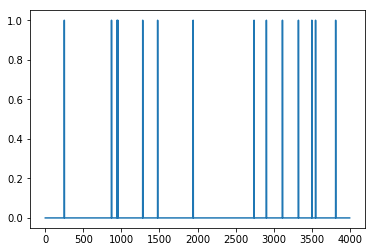

In [11]:
# Binarise the data
binarizer = Binarizer().fit(Phi_DI)
Phi_DI = binarizer.transform(Phi_DI)
Phi_DS = binarizer.transform(Phi_DS)
plt.plot(Phi_DI[:,10])

In [12]:
M = np.dot(Phi_DS.T, Phi_DI)
M.shape

(9500, 500)

In [13]:
m = X.shape[1]
A = np.c_[np.zeros((m-l, m-l)), M]
A = np.r_[A, np.c_[M.T, np.zeros((l,l))]]
A.shape

(10000, 10000)

In [14]:
# Diagonal matrix D
sum_col = np.sum(A, axis = 1)
D_inv_sqrt = np.diag(1/np.sqrt(sum_col))

In [15]:
k = 100 # clusters
L = np.dot(D_inv_sqrt,A).dot(D_inv_sqrt)
W, V = np.linalg.eig(L) # really slow

(9500, 100)

/Users/meichenlu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


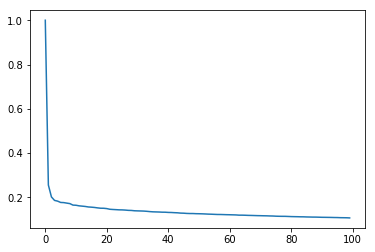

In [16]:
idx = W.argsort()[::-1]
U = V[:m-l, idx[:k]]
U = np.abs(U)
U.shape
plt.plot(W[idx[:100]])

In [28]:
u1 = U[:,1]
u1_sorted = sorted(range(len(u1)), key=lambda i: u1[i])
u1_pos_subspace = [DS_features[i] for i in u1_sorted[-1:-21:-1]]
u1_neg_subspace = [DS_features[i] for i in u1_sorted[:20]]
print(np.asarray(u1_pos_subspace))
print(np.asarray(u1_neg_subspace))

['jupitor' 'jupitor_hollow' 'sadie' 'mixed_up' 'tomlin' 'lily_tomlin'
 'and_family' 'dozen' 'twins' 'midler' 'bette_midler' 'patty' 'hollow'
 'enjoy_a' 'laughter' 'chips' 'scraping' 'my_god' 'in_big' 'good_old']
['set_the' 'email' 'thing' 'found_that' 'the_recipe' 'for_several' 'pie'
 'i_rented' 'however_they' 'give_you' 'uses_the' "she_doesn't" 'the_weight'
 'the_beautiful' 'picked' 'the_battle' 'do_not' 'half_of' 'adaptation_of'
 'inches']


In [18]:
# Augmented feature space
X_DS = X[:, sort_idx[l:]] # Non-binarised version
mapping_matrix = np.dot(X_DS,U)
gamma = 0.6
X_aug = np.c_[X, gamma*mapping_matrix]

In [19]:
X_src_aug = X_aug[:X_src.shape[0], :]
X_tgt_aug = X_aug[X_src.shape[0]:, :]

In [20]:
def tune_reg_param_unsupervised(C_test, X_src_SCL, Y_src, X_tgt, Y_tgt, dev_size):
    X_train, X_dev, Y_train, Y_dev = train_test_split(X_src_SCL, Y_src, test_size = dev_size, random_state = 3)
    acc_train = []
    acc_dev = []
    for C in C_test:
        model_SCL = LogisticRegression(C = C) 
        model_SCL.fit(X_train, Y_train)
        acc_train.append(model_SCL.score(X_train, Y_train))
        acc_dev.append(model_SCL.score(X_dev, Y_dev))
    C_opt = C_test[np.argmax(acc_dev)]
    model_SCL = LogisticRegression(C = C_opt) 
    model_SCL.fit(X_train, Y_train)
    print('optimal alpha', C_opt, 'max acc', max(acc_dev),'test acc', model_SCL.score(X_tgt, Y_tgt))
    plt.plot(C_test, acc_train)
    plt.plot(C_test, acc_dev)

optimal alpha 0.0621052631579 max acc 0.83 test acc 0.7665


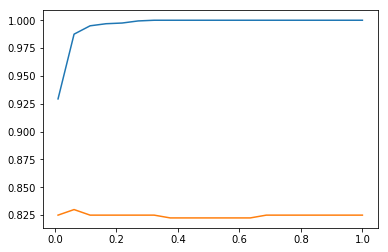

In [21]:
C_test = np.linspace(0.01,1,20)
tune_reg_param_unsupervised(C_test, X_src_aug, Y_src, X_tgt_aug, Y_tgt, 0.2)

In [22]:
gamma_list = np.logspace(-3,2,6)
for gamma in gamma_list:
    X_aug = np.c_[X, gamma*mapping_matrix]
    X_src_aug = X_aug[:X_src.shape[0], :]
    X_tgt_aug = X_aug[X_src.shape[0]:, :]
    model = LogisticRegression(C = 0.1) 
    model.fit(X_src_aug, Y_src)
    print('gamma: {}, train {:s} acc: {:.3f}, test {:s} acc: {:.3f}'\
          .format(gamma, src, model.score(X_src_aug, Y_src), tgt, model.score(X_tgt_aug,Y_tgt)))

gamma: 0.001, train dvd acc: 0.993, test kitchen acc: 0.772
gamma: 0.01, train dvd acc: 0.993, test kitchen acc: 0.772
gamma: 0.1, train dvd acc: 0.993, test kitchen acc: 0.772
gamma: 1.0, train dvd acc: 0.993, test kitchen acc: 0.774
gamma: 10.0, train dvd acc: 0.990, test kitchen acc: 0.777
gamma: 100.0, train dvd acc: 0.971, test kitchen acc: 0.761
